In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random
from random import random as rand

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
subj_list = ['03','04','05','06','07',
             '08','09','10','11','12',
             '14','15','16','17','18',
             '19','20','21','22','24',
             '25','26','27','29']

In [4]:
today = date.today().strftime("%Y%m%d")
root_dir = '..'
behav_dir = root_dir + '/behav_data'
script_dir = root_dir + '/scripts'
output_dir = script_dir

In [5]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
sec_per_trial = 4  ## time spend(second) in each trial
ntrial = 12
nblock = 12
tt = 12*4 # total number of blocks = 12 blocks/run * 4 runs

In [6]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [7]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    nS = int(datum['nSampleTrial'][0][0])
    tpr = int(datum['nTrialperRun'][0][0])   # 1 + 12 trials/block * 12 blocks
    nrun = int(datum['nRun'][0][0])

    temp = datum['LearnTrialStartTime'][0]
    idx_editpoint = [i+1 for i,t in enumerate(temp[:-2]) if (temp[i]>temp[i+1])]

    cnt_hit_all = np.zeros((tpr*nrun,nS), dtype=bool)
    for t,ID in enumerate(datum['targetID'][0][idx_editpoint[0]:]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # allXY.shape = (2, 60 Hz * 4 s/trial * 145 trials/run * 6 runs = 208800 frames)
        err = xy - np.ones((2,nS))*pos.T     # err.shape = (2, nS)
        cnt_hit_all[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)

    rew_bin = np.zeros((nrun,sec_per_trial*tpr))
    for r in range(nrun):
        temp = cnt_hit_all[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(sec_per_trial*tpr):
            rew_bin[r,i] = sum(temp[60*i:60*(i+1)])

    max_score =  nS*ntrial   ## total frames in a block
    temp = rew_bin[:,sec_per_trial:].reshape(nrun*sec_per_trial*ntrial*nblock)
    norm_mrew = np.zeros(nblock*nrun)
    for i in range(nblock*nrun):
        norm_mrew[i] = sum(temp[sec_per_trial*ntrial*i:sec_per_trial*ntrial*(i+1)])/max_score

    return norm_mrew

In [8]:
# def gr4allXY(run):
#     ## get a range for allXY
#     s = 60*4        # sample rate
#     tpb = ntrial        # trials per block
#     tpr = tpb*nblock + 1  # trials per run
#     switcher = {
#         'r01':np.arange(0,s*tpr),
#         'r02':np.arange(s*tpr,s*tpr*2),
#         'r03':np.arange(s*tpr*2,s*tpr*3),
#         'r04':np.arange(s*tpr*3,s*tpr*4),
#         'r05':np.arange(s*tpr*4,s*tpr*5),
#         'r06':np.arange(s*tpr*5,s*tpr*6),
#         'r07':np.arange(s*tpr*6,s*tpr*7),
#         'b01':np.arange(s,s+s*tpb),
#         'b02':np.arange(s+s*tpb,s+s*tpb*2),
#         'b03':np.arange(s+s*tpb*2,s+s*tpb*3),
#         'b04':np.arange(s+s*tpb*3,s+s*tpb*4),
#         'b05':np.arange(s+s*tpb*4,s+s*tpb*5),
#         'b06':np.arange(s+s*tpb*5,s+s*tpb*6),
#         'b07':np.arange(s+s*tpb*6,s+s*tpb*7),
#         'b08':np.arange(s+s*tpb*7,s+s*tpb*8),
#         't01':np.arange(0,s),
#         't02':np.arange(s,s*2),
#         't03':np.arange(s*2,s*3),
#         't04':np.arange(s*3,s*4),
#         't05':np.arange(s*4,s*5),
#         't06':np.arange(s*5,s*6),
#         't07':np.arange(s*6,s*7),
#         't08':np.arange(s*7,s*8),
#         't09':np.arange(s*8,s*9),
#         't10':np.arange(s*9,s*10),
#         't11':np.arange(s*10,s*11),
#         't12':np.arange(s*11,s*12)
#     }
#     return switcher.get(run,"Invalid RUN")

# Success rate

In [9]:
rew = {}
for nn in subj_list:
    subj = 'GL' + nn
    behav_datum = behav_dir + '/%s-fmri.mat' %subj
    rew[subj] = calc_mrew(behav_datum)
    print(subj, end='\r')

In [10]:
df = pd.DataFrame()
for nn in subj_list:
    subj = 'GL' + nn
    for i,r in enumerate(rew[subj]):
        df.loc[subj,i] = r

sum_even = 0;
sum_odd = 0;
for i in range(tt):
    if i % 2 == 0:
        sum_even += df[i]
    else:
        sum_odd += df[i]
df['FB'] = sum_even
df['nFB'] = sum_odd
df['diff'] = df['FB'] - df['nFB']
df.to_csv('./RewardRate_FB.txt', columns=['FB'], header=None, index=None)
df.to_csv('./RewardRate_nFB.txt', columns=['nFB'], header=None, index=None)
df.to_csv('./RewardRate_diff.txt', columns=['diff'], header=None, index=None)
df

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,FB,nFB,diff
GL03,0.076389,0.000347,0.075694,0.050347,0.066319,0.073611,0.247917,0.076389,0.272917,0.090625,...,0.746528,0.649653,0.579167,0.411458,0.560069,0.622569,0.526736,11.168750,3.140278,8.028472
GL04,0.287153,0.313194,0.384722,0.176736,0.386458,0.196181,0.485764,0.210417,0.419444,0.107986,...,0.563194,0.618403,0.392708,0.659028,0.502431,0.633333,0.654861,11.105208,3.961806,7.143403
GL05,0.092708,0.001736,0.147222,0.062500,0.204167,0.049306,0.417361,0.038194,0.086458,0.008681,...,0.454514,0.503125,0.503125,0.530903,0.413542,0.529514,0.491319,7.950694,1.734722,6.215972
GL06,0.029167,0.021528,0.073264,0.012847,0.207292,0.131597,0.124653,0.014583,0.169444,0.072917,...,0.413542,0.419097,0.346528,0.390625,0.415278,0.396181,0.403819,7.409375,1.997917,5.411458
GL07,0.128819,0.018056,0.213889,0.014236,0.222917,0.034028,0.231597,0.009375,0.105556,0.022917,...,0.440278,0.401389,0.279167,0.255208,0.181597,0.416667,0.319444,5.570139,1.043750,4.526389
GL08,0.175694,0.009028,0.345486,0.075347,0.393056,0.015625,0.320139,0.056944,0.519792,0.176736,...,0.571528,0.652431,0.531250,0.584722,0.591667,0.538194,0.549306,10.852431,3.220139,7.632292
GL09,0.107292,0.072569,0.121875,0.078125,0.090972,0.017014,0.184375,0.070486,0.097222,0.041667,...,0.574306,0.607639,0.565972,0.548611,0.607986,0.673264,0.594097,6.678819,2.532639,4.146181
GL10,0.045486,0.007986,0.058681,0.088889,0.033681,0.006250,0.165625,0.007639,0.253819,0.035764,...,0.230208,0.330556,0.448611,0.369444,0.298611,0.407639,0.367014,7.211111,2.820139,4.390972
GL11,0.149306,0.004514,0.004514,0.039931,0.303125,0.218056,0.317708,0.290278,0.383681,0.201389,...,0.762500,0.628125,0.678819,0.709375,0.610069,0.596528,0.512500,9.195486,2.566319,6.629167
GL12,0.054514,0.016667,0.021528,0.025347,0.007292,0.016667,0.018056,0.011111,0.100347,0.076042,...,0.345139,0.332292,0.346875,0.409375,0.349653,0.261458,0.258681,3.652431,1.185417,2.467014


Text(0.5, 0, 'blocks')

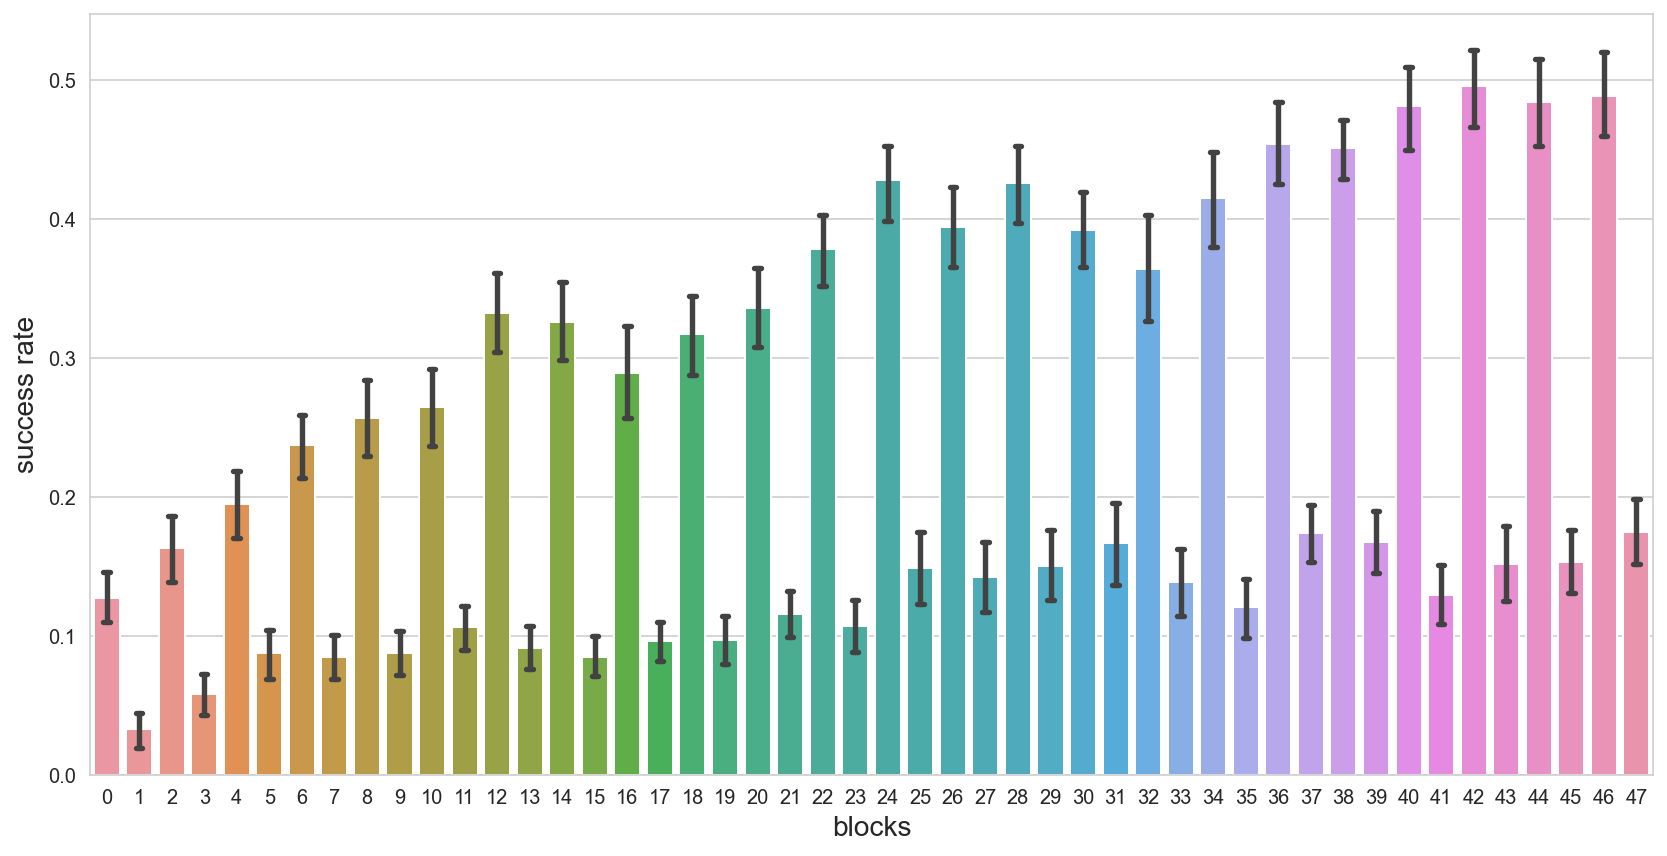

In [11]:
plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')
sns.barplot(data=df[range(tt)], ci=100*sigma_1, capsize=.2)
plt.ylabel('success rate', size=14)
plt.xlabel('blocks', size=14)

In [12]:
## wide to long
dk = df.reset_index().melt(id_vars='index' ,value_vars=df.columns[:tt])
dk['hue'] = ['FB' if (col%2==0) else 'nFB' for col in dk['variable']]
dk

,index,variable,value,hue
0,GL03,0,0.076389,FB
1,GL04,0,0.287153,FB
2,GL05,0,0.092708,FB
3,GL06,0,0.029167,FB
4,GL07,0,0.128819,FB
...,...,...,...,...
1147,GL24,47,0.056944,nFB
1148,GL25,47,0.217708,nFB
1149,GL26,47,0.190625,nFB
1150,GL27,47,0.076042,nFB


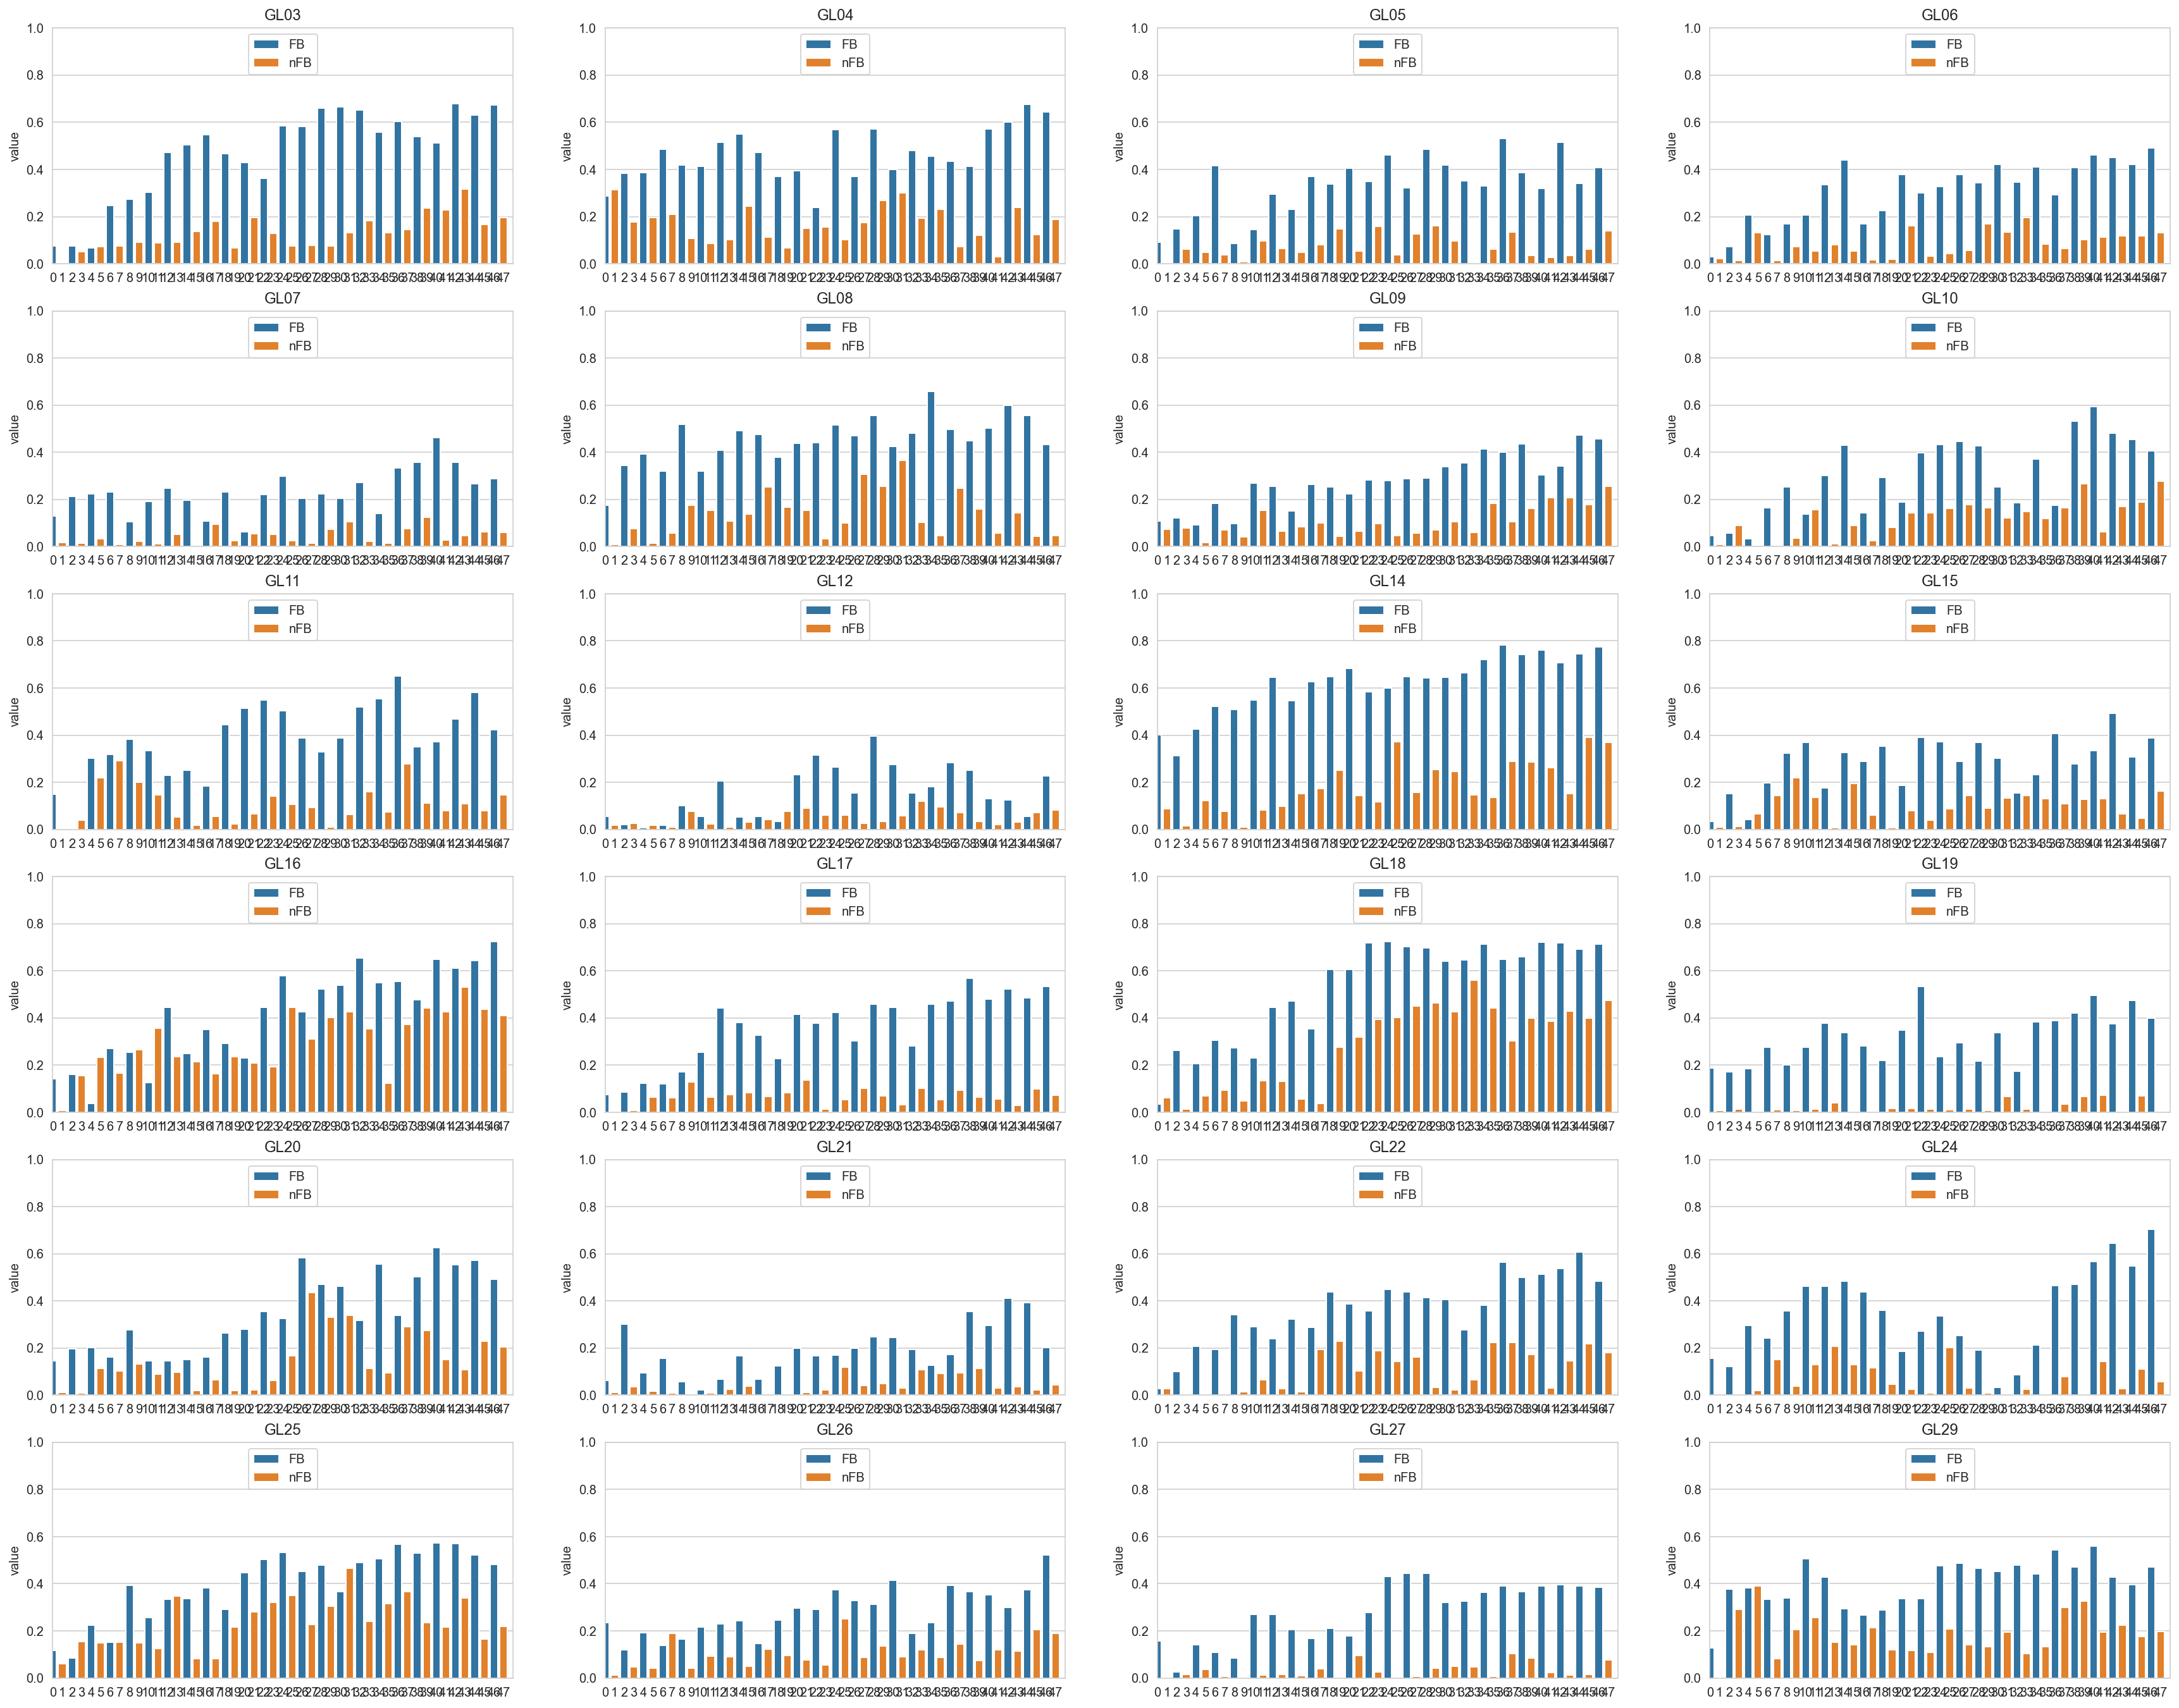

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 24)
sns.set_style('whitegrid')
for i, nn in enumerate(subj_list):
    subj = 'GL' + nn
    plt.subplot(6, 4, i+1)
#     sns.scatterplot(data=df.loc[subj][:tt])
#     sns.barplot(x=np.arange(32), y=df.loc[subj][np.arange(32)])
    sns.barplot(x='variable', y='value', data=dk[dk['index']==subj], hue='hue', dodge=False)
    plt.title(subj)
    plt.ylim(0, 1)
    plt.xlim(0, tt)
    plt.xlabel(None)
    plt.legend()

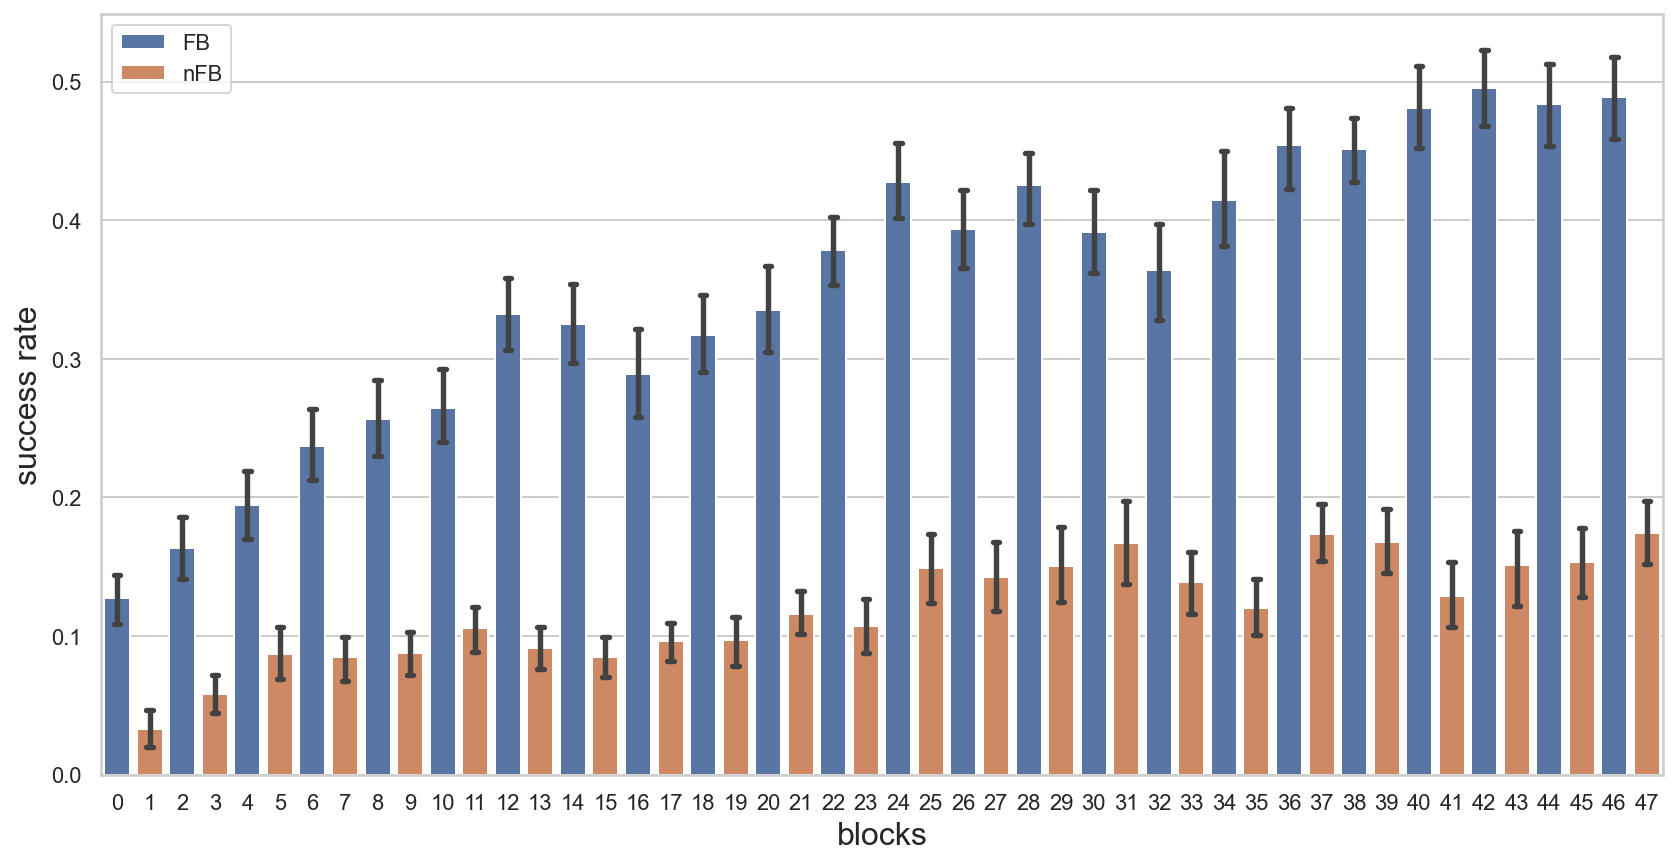

In [14]:
sns.set(style="whitegrid")

ax = plt.figure(figsize=(14, 7))
sns.barplot(x='variable', y='value', data=dk, hue='hue', ci=100*sigma_1, capsize=.2, dodge=False)
plt.ylabel('success rate', size=16)
plt.xlabel('blocks', size=16)
plt.legend()

# ax.savefig(join(output_dir,today+'.behav.group.png'), dpi=300)